# **Study of energy dissipation for PTST ligament - PVW approach**

Study not included at Euro-C. The notebook can be reused for calibration

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from bmcs_matmod.ms1 import MS13DPVW
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy

In [2]:
def get_damage(m):   
    radial_damage = []
    hoop_damage = []
    shear_damage = []

    for i in range(len(m.hist.state_vars)):
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        # beta_T = 0.75*copy.deepcopy(beta_T) +0.25*copy.deepcopy(beta_T)*copy.deepcopy(beta_N)
        delta = m_inelastic.DELTA

        beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        radial_damage.append(1-(beta_ijkl**2)[0,1,1,1,1])
        hoop_damage.append(1-(beta_ijkl**2)[0,2,2,2,2])
        shear_damage.append(1-((beta_ijkl)[0,1,0,1,0]*2)**2)
    return radial_damage, hoop_damage, shear_damage


In [3]:
def get_omega_N(m):
    omega_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_N_11[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_N_01[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
    return omega_N_01, omega_N_11 

In [4]:
def get_omega_T(m):
    omega_T_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_T_11[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_T_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_T_01[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        
    return omega_T_01, omega_T_11   

In [5]:
def get_sigma_N(m):
    
    sigma_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        sigma_N_11[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
        
    sigma_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        sigma_N_01[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
        
    sigma_T_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_T_Emna = m_inelastic._get_e_T_Emna(eps_Emab)
        eps_T_Emna = np.array([ eps_T_Emna[0,0][j][:] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        E_T = m_inelastic.E * (1.0 - 4 * m_inelastic.nu) / \
            ((1.0 + m_inelastic.nu) * (1.0 - 2 * m_inelastic.nu))
        omega_T_Emn = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        eps_T_pi_Emna = np.array([ m.hist.state_vars[i][0]['eps_T_pi_Emna'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        sigma_T_11_vector = np.einsum(
            '...n,...na->...na', (1 - omega_T_Emn), E_T * (eps_T_Emna - eps_T_pi_Emna))
        sigma_T_11[i] = np.linalg.norm(sigma_T_11_vector,axis=-1)
        
    sigma_T_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_T_Emna = m_inelastic._get_e_T_Emna(eps_Emab)
        eps_T_Emna = np.array([ eps_T_Emna[0,0][j][:] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        E_T = m_inelastic.E * (1.0 - 4 * m_inelastic.nu) / \
            ((1.0 + m_inelastic.nu) * (1.0 - 2 * m_inelastic.nu))
        omega_T_Emn = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        eps_T_pi_Emna = np.array([ m.hist.state_vars[i][0]['eps_T_pi_Emna'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        sigma_T_01_vector = np.einsum(
            '...n,...na->...na', (1 - omega_T_Emn), E_T * (eps_T_Emna - eps_T_pi_Emna))
        sigma_T_01[i] = np.linalg.norm(sigma_T_01_vector,axis=-1)
    
    sigma_radial = np.zeros(len(m.hist.state_vars))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        eps_T_pi_Emna = np.average(m.hist.state_vars[i][0]['eps_T_pi_Emna'],axis=1)
        eps_N_p_Emn = np.average(m.hist.state_vars[i][0]['eps_N_p_Emn'],axis=1)
        
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        # beta_T = 0.75*copy.deepcopy(beta_T) +0.25*copy.deepcopy(beta_T)*copy.deepcopy(beta_N)
        delta = m_inelastic.DELTA

        beta_Emabcd = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        D_Emabcd = np.einsum(
                     '...ijab, abef, ...cdef->...ijcd',
                     beta_Emabcd, m_inelastic.D_abef, beta_Emabcd
                )

        eps_p_Emab = (
        np.einsum('n,...n,na,nb->...ab',
                  m_inelastic._MPW, eps_N_p_Emn, m_inelastic._MPN, m_inelastic._MPN) +
        0.5 * (
                np.einsum('n,...nf,na,fb->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA) +
                np.einsum('n,...nf,nb,fa->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA)
        )
        )
        eps_e_Emab = eps_Emab - eps_p_Emab

        sig_Emab = np.einsum(
            '...abcd,...cd,...ab->...ab',
            D_Emabcd, eps_e_Emab, m_inelastic.DELTA
                ) 
        sigma_11 = sig_Emab[0,:,1,1]
        sigma_radial[i] = max(sigma_11)
        
    return sigma_N_01, sigma_N_11, sigma_T_01, sigma_T_11, sigma_radial

In [6]:
def get_sigma(m,idx):

    sigma_radial = np.zeros(len(m.hist.state_vars))
    sigma_hoop = np.zeros(len(m.hist.state_vars))
    sigma_shear = np.zeros(len(m.hist.state_vars))
    
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        eps_T_pi_Emna = np.average(m.hist.state_vars[i][0]['eps_T_pi_Emna'],axis=1)
        eps_N_p_Emn = np.average(m.hist.state_vars[i][0]['eps_N_p_Emn'],axis=1)
        
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        # beta_T = 0.75*copy.deepcopy(beta_T) + 0.25**copy.deepcopy(beta_T)**copy.deepcopy(beta_N)
        delta = m_inelastic.DELTA
        beta_Emabcd = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        D_Emabcd = np.einsum(
                     '...ijab, abef, ...cdef->...ijcd',
                     beta_Emabcd, m_inelastic.D_abef, beta_Emabcd
                )

        eps_p_Emab = (
        np.einsum('n,...n,na,nb->...ab',
                  m_inelastic._MPW, eps_N_p_Emn, m_inelastic._MPN, m_inelastic._MPN) +
        0.5 * (
                np.einsum('n,...nf,na,fb->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA) +
                np.einsum('n,...nf,nb,fa->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA)
        )
        )
        eps_e_Emab = eps_Emab - eps_p_Emab

        sig_Emab = np.einsum(
            '...abcd,...cd,...ab->...ab',
            D_Emabcd, eps_e_Emab, m_inelastic.DELTA
                ) 
        sigma_11 = sig_Emab[0,:,1,1]
        sigma_22 = sig_Emab[0,:,2,2]
        sigma_01 = sig_Emab[0,:,0,1]
        
        sigma_radial[i] = sigma_11[idx]
        sigma_hoop[i] = sigma_22[idx]
        sigma_shear[i] = sigma_01[idx]

    return sigma_radial, sigma_hoop, sigma_shear

In [7]:
def get_energy_dissip(m):
        
    plastic_normal_dissipation = np.zeros((len(m.hist.state_vars),4))
    plastic_tangential_dissipation = np.zeros((len(m.hist.state_vars),4))
    
    damage_normal_dissipation = np.zeros((len(m.hist.state_vars),4))
    damage_tangential_dissipation = np.zeros((len(m.hist.state_vars),4))
    
    delta_z_T_Emn = np.zeros((len(m.hist.state_vars),4,28))
    delta_alpha_T_Emna = np.zeros((len(m.hist.state_vars),4,28,3))
    delta_eps_T_pi_Emna = np.zeros((len(m.hist.state_vars),4,28,3))
    sigma_T_Emna = np.zeros((len(m.hist.state_vars),4,28,3))
    Z_T = np.zeros((len(m.hist.state_vars),4,28))
    X_T = np.zeros((len(m.hist.state_vars),4,28,3))
    
    for i in range(1,len(m.hist.state_vars)):
        
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn(eps_Emab)       
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn']])
        
        pos = eps_N_Emn - eps_N_p_Emn > 1e-15  # microplanes under traction
        pos2 = eps_N_Emn - eps_N_p_Emn < -1e-15
        tension = 1.0 * pos
        compression = 1.0 * pos2
        
        delta_z_N_Emn = np.array([ m.hist.state_vars[i][0]['z_N_Emn']]) - np.array([ m.hist.state_vars[i-1][0]['z_N_Emn']])
        delta_alpha_N_Emn = np.array([ m.hist.state_vars[i][0]['alpha_N_Emn']]) - np.array([ m.hist.state_vars[i-1][0]['alpha_N_Emn']])
        delta_eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn']]) - np.array([ m.hist.state_vars[i-1][0]['eps_N_p_Emn']])
        delta_r_N_Emn = np.array([ m.hist.state_vars[i][0]['r_N_Emn']]) - np.array([ m.hist.state_vars[i-1][0]['r_N_Emn']])
        delta_omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn']]) - np.array([ m.hist.state_vars[i-1][0]['omega_N_Emn']])
        
        Z = compression * m_inelastic.K_N * np.array([ m.hist.state_vars[i][0]['z_N_Emn']])
        X = compression * m_inelastic.gamma_N * np.array([ m.hist.state_vars[i][0]['alpha_N_Emn']])
        sigma_N = (1.0 - np.array([ m.hist.state_vars[i][0]['omega_N_Emn']]) ) * E_N * (eps_N_Emn - eps_N_p_Emn) * tension
        sigma_N = E_N * (eps_N_Emn - eps_N_p_Emn) * compression
                                  
        Y_N = 0.5 *  tension * E_N * (eps_N_Emn - eps_N_p_Emn) ** 2.0 
        R_N = tension * (1.0 / m_inelastic.Ad) * (-np.array([ m.hist.state_vars[i][0]['r_N_Emn']]) / (1.0 + np.array([ m.hist.state_vars[i][0]['r_N_Emn']])))
        
        plastic_normal_dissipation_micro = (np.einsum('...n,...n->...n', sigma_N, delta_eps_N_p_Emn) - np.einsum('...n,...n->...n', Z, delta_z_N_Emn) - np.einsum('...n,...n->...n', X, delta_alpha_N_Emn))
        damage_normal_dissipation_micro = (np.einsum('...n,...n->...n', Y_N, delta_omega_N_Emn) - np.einsum('...n,...n->...n', R_N, delta_r_N_Emn)) 
        plastic_normal_dissipation[i] =  np.einsum('...n,...n->...', m_inelastic._MPW, plastic_normal_dissipation_micro)
        damage_normal_dissipation[i] =  np.einsum('...n,...n->...', m_inelastic._MPW, damage_normal_dissipation_micro)
                                                 
        # if (plastic_normal_dissipation < -1e-15).any():
        #     print("2nd law thermo violation normal plastic")
        # if (damage_normal_dissipation < -1e-15).any:
        #     print("2nd law thermo violation normal damage")
                                                 
        
        eps_T_Emna = m_inelastic._get_e_T_Emna(eps_Emab)       
        E_T =  m_inelastic.E * (1.0 - 4 * m_inelastic.nu) / \
            ((1.0 + m_inelastic.nu) * (1.0 - 2 * m_inelastic.nu))
        eps_T_pi_Emna = np.array([m.hist.state_vars[i][0]['eps_T_pi_Emna']])
    
        
        delta_z_T_Emn[i] = np.array([ m.hist.state_vars[i][0]['z_T_Emn']]) - np.array([ m.hist.state_vars[i-1][0]['z_T_Emn']])
        delta_alpha_T_Emna[i] = np.array([ m.hist.state_vars[i][0]['alpha_T_Emna']]) - np.array([ m.hist.state_vars[i-1][0]['alpha_T_Emna']])
        delta_eps_T_pi_Emna[i] = np.array([ m.hist.state_vars[i][0]['eps_T_pi_Emna']]) - np.array([ m.hist.state_vars[i-1][0]['eps_T_pi_Emna']])
        delta_omega_T_Emn = np.array([ m.hist.state_vars[i][0]['omega_T_Emn']]) - np.array([ m.hist.state_vars[i-1][0]['omega_T_Emn']])
        
        sigma_T_Emna[i] = np.einsum(
            '...n,...na->...na', (1 - np.array([ m.hist.state_vars[i][0]['omega_T_Emn']])), E_T * (eps_T_Emna - eps_T_pi_Emna))
        Z_T[i] = m_inelastic.K_T * np.array([ m.hist.state_vars[i][0]['z_T_Emn']])
        X_T[i] = m_inelastic.gamma_T * np.array([ m.hist.state_vars[i][0]['alpha_T_Emna']])
        Y_T = 0.5 * E_T * np.einsum('...na,...na->...n',(eps_T_Emna - eps_T_pi_Emna),(eps_T_Emna - eps_T_pi_Emna))

        plastic_tangential_dissipation_micro = (np.einsum('...na,...na->...n', sigma_T_Emna[i], delta_eps_T_pi_Emna[i]) - np.einsum('...n,...n->...n', Z_T[i], delta_z_T_Emn[i]) - np.einsum('...na,...na->...n', X_T[i], delta_alpha_T_Emna[i]))
        damage_tangential_dissipation_micro = (np.einsum('...n,...n->...n', Y_T, delta_omega_T_Emn)) 
                
        plastic_tangential_dissipation[i] =  np.einsum('...n,...n->...', m_inelastic._MPW, plastic_tangential_dissipation_micro)
        damage_tangential_dissipation[i] =  np.einsum('...n,...n->...', m_inelastic._MPW, damage_tangential_dissipation_micro)
                                                 
        # if (plastic_tangential_dissipation < -1e-15).any:
        #     print("2nd law thermo violation tangential plastic")
        # if (damage_tangential_dissipation < -1e-15).any:
        #     print("2nd law thermo violation tangential damage")
                                                 
    return plastic_normal_dissipation, damage_normal_dissipation, plastic_tangential_dissipation, damage_tangential_dissipation, delta_z_T_Emn, delta_alpha_T_Emna, delta_eps_T_pi_Emna, sigma_T_Emna, Z_T, X_T

In [8]:
def get_forces(m):
    
    eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
    omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
    omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
    eps_T_pi_Emna = np.average(m.hist.state_vars[i][0]['eps_T_pi_Emna'],axis=1)
    eps_N_p_Emn = np.average(m.hist.state_vars[i][0]['eps_N_p_Emn'],axis=1)
    

In [9]:
# Reference parameters

CAxisymm = dict(
    E = 39226,
    nu = 0.18,
    Ad = 700.0,
    eps_0 = 0.00001,
    K_N = 100.,
    sigma_N_0 = 20.,
    gamma_N = 200.,
    sigma_T_0 = 0.5,
    K_T = 0.0,
    gamma_T = 500,
    S_T = 0.001,
    c_T = 6.,
    r_T = 4.,
    m_T = 0.0,
    p_T = 10.
)

## Unit element Axisymm 

In [10]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 4 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13DPVW(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [11]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [12]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


## Monotonic - dc

In [13]:
m_list_monotnonic = []
# CAxisymm['m_T'] = 0.15
# CAxisymm['p_T'] = 7
# m_inelastic = MS13D(**CAxisymm)
# compression_level = np.linspace(-20,10,3)
compression_level = np.array([-15])

w_max = 0.1

for compression in compression_level:
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    slide = 0.05
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch  / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_precrompression)
                               for dof in confinement_upper_dofs]
    

    
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5

    slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                         for dof in slide_upper_dofs]
    
#     slide_upper[0].value *= 1.5
#     slide_upper[-1].value *= 0.5
    
    
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = True
    s.tloop.k_max = 1000
    s.tline.step = 0.02
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    s.run()
    # try:
    #     s.run()
    # except:
    #     # m_list_monotnonic.append(m)
    #     pass
    m_list_monotnonic.append(m)

t:	 0.00(0), 
	 0.02(5), 
	 0.04(9), 
	 0.06(9), 
	 0.08(9), 
	 0.10(40), 
	 0.12(40), 
	 0.14(65), 
	 0.16(82), 
	 0.18(103), 
	 0.20(105), 
	 0.22(113), 
	 0.24(119), 
	 0.26(127), 
	 0.28(139), 
	 0.30(153), 
	 0.32(170), 
	 0.34(193), 
	 0.36(222), 
	 0.38(256), 
	 0.40(298), 
	 0.42(348), 
	 0.44(401), 
	 0.46(39), 
	 0.48(37), 
	 0.50(37), 
	 0.52(37), 
	 0.54(37), 
	 0.56(37), 
	 0.58(37), 
	 0.60(37), 
	 0.62(37), 
	 0.64(37), 
	 0.66(37), 
	 0.68(37), 
	 0.70(37), 
	 0.72(37), 
	 0.74(37), 
	 0.76(37), 
	 0.78(37), 
	 0.80(37), 
	 0.82(37), 
	 0.84(37), 
	 0.86(37), 
	 0.88(37), 
	 0.90(37), 
	 0.92(37), 
	 0.94(37), 
	 0.96(37), 
	 0.98(37), 
	 1.00(37), 



Text(0.5, 0.01, "{'E': 39226, 'nu': 0.18, 'Ad': 700.0, 'eps_0': 1e-05, 'K_N': 100.0, 'sigma_N_0': 20.0, 'gamma_N': 200.0, 'sigma_T_0': 0.5, 'K_T': 0.0, 'gamma_T': 500, 'S_T': 0.001, 'c_T': 6.0, 'r_T': 4.0, 'm_T': 0.0, 'p_T': 10.0}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
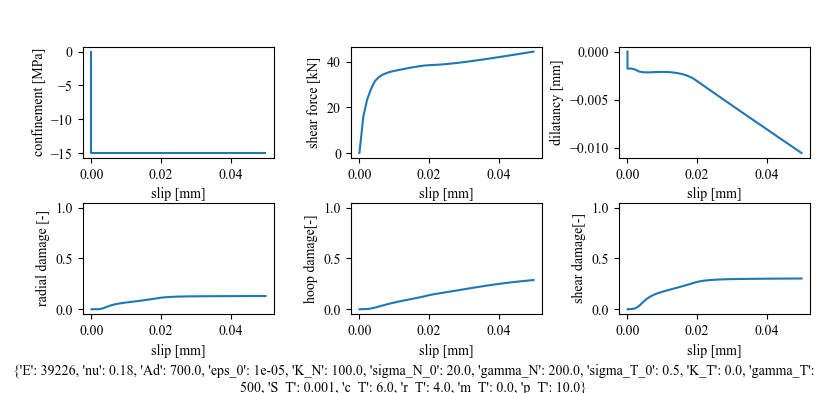

In [15]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"




fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 10*cm))



for m,compression in zip(m_list_monotnonic,compression_level):
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    radial_damage, hoop_damage, shear_damage = get_damage(m)

    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    max_F.append(max(abs(F_slide)))
    
    ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    ax1.set_ylabel('confinement [MPa]', fontsize=10)
    ax1.set_xlabel('slip [mm]', fontsize=10)
    
    ax2.plot(U_slide, F_slide/1000, label=str(compression))
    ax2.set_ylabel('shear force [kN]', fontsize=10)
    ax2.set_xlabel('slip [mm]', fontsize=10)
    
    ax3.plot(U_slide, U_dilatancy, label=str(compression))
    ax3.set_ylabel('dilatancy [mm]', fontsize=10)
    ax3.set_xlabel('slip [mm]', fontsize=10)
    
    
    # ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.set_ylabel('radial damage [-]', fontsize=10)
    ax4.set_xlabel('slip [mm]', fontsize=10)
    ax4.set_ylim(-0.05,1.05)
    
    ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
    ax5.set_ylabel('hoop damage[-]', fontsize=10)
    ax5.set_xlabel('slip [mm]', fontsize=10)
    ax5.set_ylim(-0.05,1.05)
    
    # ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
    ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
    ax6.set_ylabel('shear damage[-]', fontsize=10)
    ax6.set_xlabel('slip [mm]', fontsize=10)
    ax6.set_ylim(-0.05,1.05)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
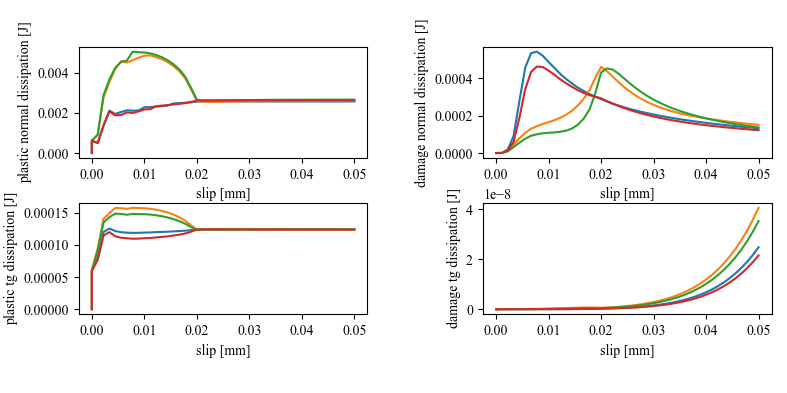

In [17]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"




fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2,figsize=(20*cm, 10*cm))



#for m,compression in zip(m_list_monotnonic[0],compression_level[0]):
m = m_list_monotnonic[0]
compression = compression_level[0]
U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
plastic_normal_dissipation, damage_normal_dissipation, plastic_tangential_dissipation, damage_tangential_dissipation, delta_z_T_Emn, delta_alpha_T_Emna, delta_eps_T_pi_Emna, sigma_T_Emna, Z_T, X_T\
    = get_energy_dissip(m)
F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
max_F.append(max(abs(F_slide)))

ax1.plot(U_slide, plastic_normal_dissipation)
ax1.set_ylabel('plastic normal dissipation [J]', fontsize=10)
ax1.set_xlabel('slip [mm]', fontsize=10)

ax2.plot(U_slide, damage_normal_dissipation)
ax2.set_ylabel('damage normal dissipation [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_slide, plastic_tangential_dissipation)
ax3.set_ylabel('plastic tg dissipation [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)


ax4.plot(U_slide, damage_tangential_dissipation)
ax4.set_ylabel('damage tg dissipation [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)

plastic_dissip_T_Emn = np.zeros_like(delta_z_T_Emn)
    
    
for j in range(len(m.hist.state_vars)): 
    plastic_dissip_T_Emn[j] = np.array(m.hist.state_vars[j][0]['plastic_dissip_T_Emn'])
print(plastic_dissip_T_Emn)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [16]:
max_F

[44479.55654793643]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
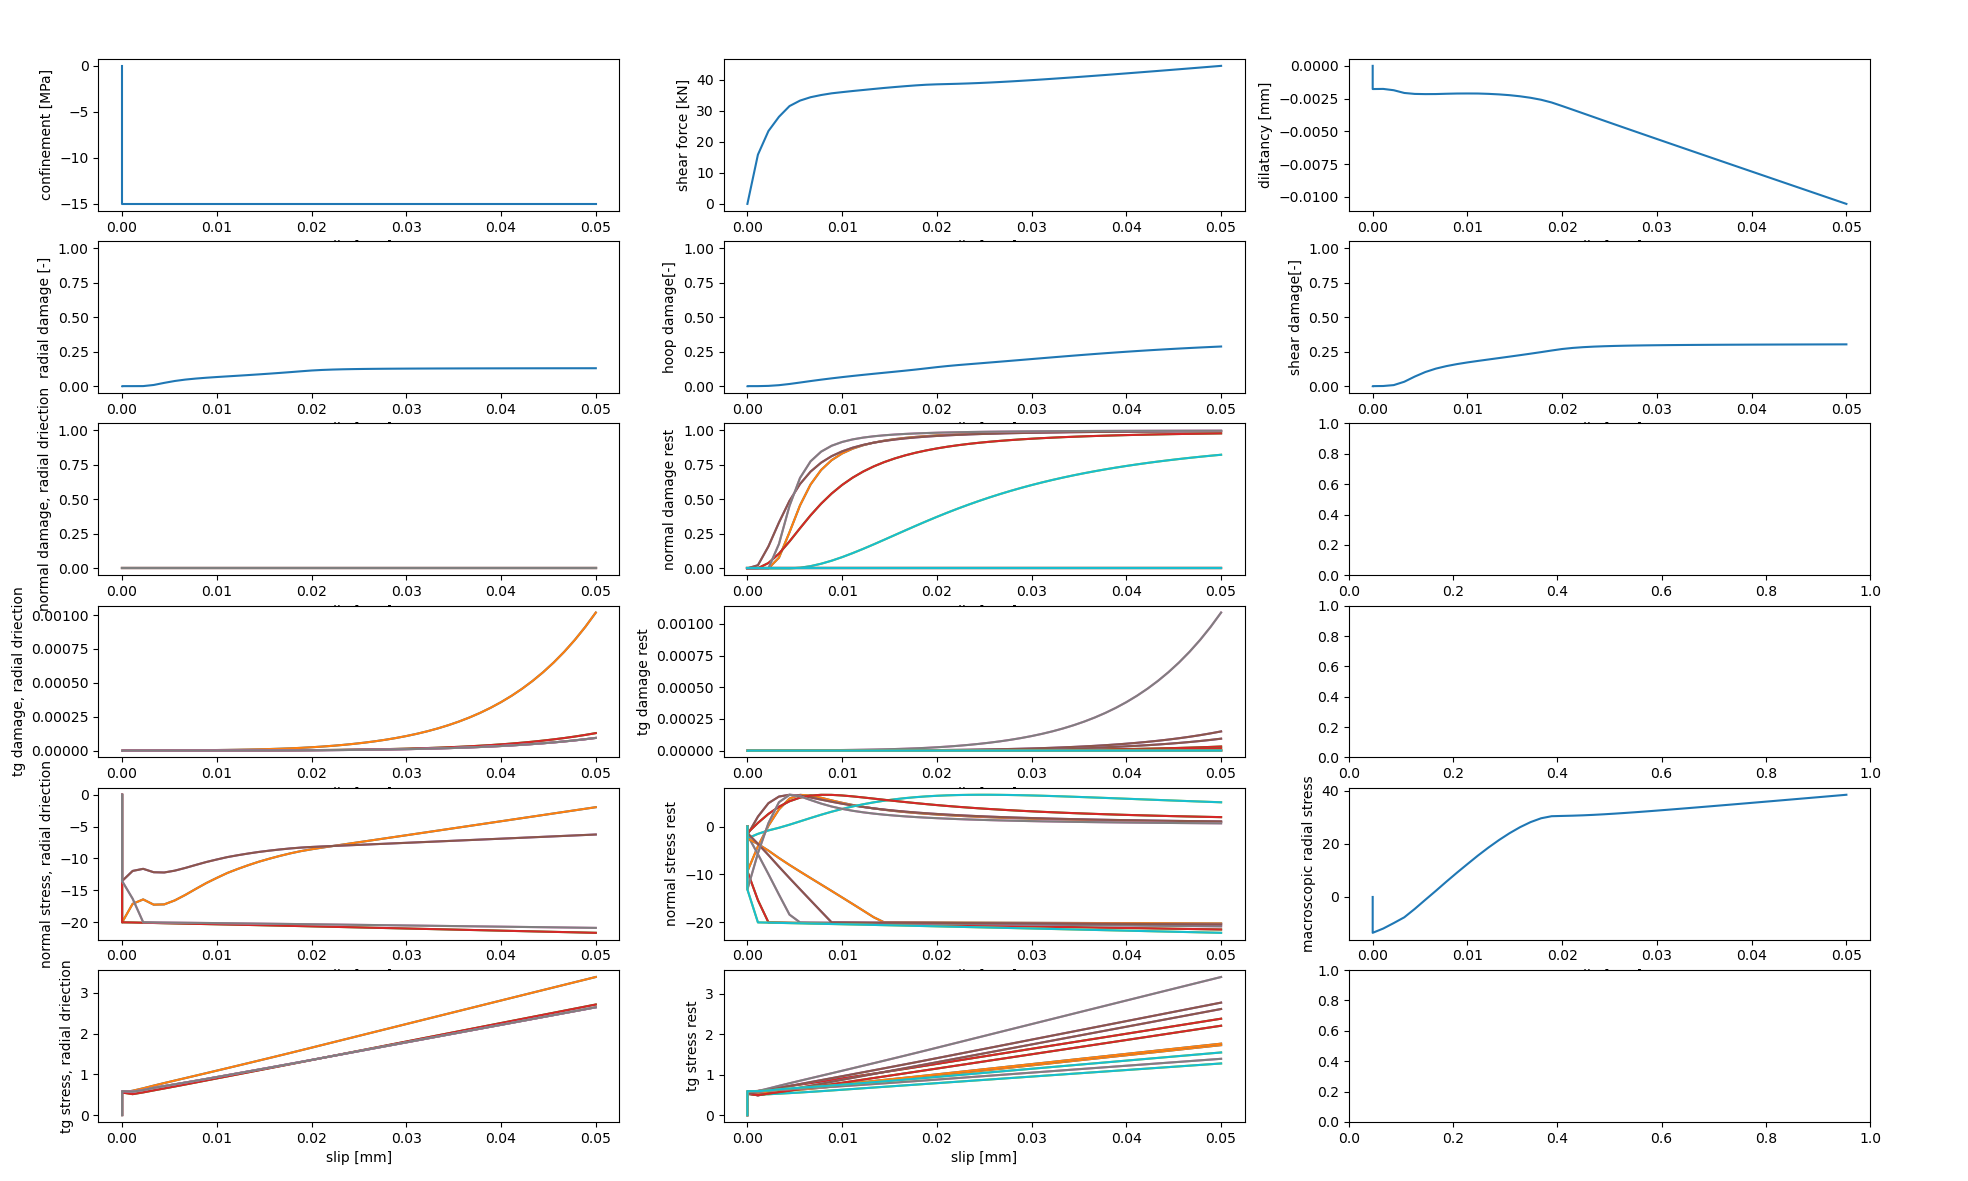

In [18]:
plt.style.use('default')

# plt.tight_layout()

cm = 1/2.54  # centimeters in inches
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9), (ax10,ax11,ax12), (ax13,ax14,ax15), (ax16,ax17,ax18)) = plt.subplots(6, 3,figsize=(50*cm, 30*cm))

# txt=str(CAxisymm)


idx = 0
m = m_list_monotnonic[idx]
compression = compression_level[idx]
# plt.rcParams["font.family"] = "Times New Roman"
 
    
U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
radial_damage, hoop_damage, shear_damage = get_damage(m)

F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)


ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
ax1.set_ylabel('confinement [MPa]', fontsize=10)
ax1.set_xlabel('slip [mm]', fontsize=10)

ax2.plot(U_slide, F_slide/1000, label=str(compression))
ax2.set_ylabel('shear force [kN]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_slide, U_dilatancy, label=str(compression))
ax3.set_ylabel('dilatancy [mm]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)


# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.set_ylabel('radial damage [-]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
ax4.set_ylim(-0.05,1.05)

ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
ax5.set_ylabel('hoop damage[-]', fontsize=10)
ax5.set_xlabel('slip [mm]', fontsize=10)
ax5.set_ylim(-0.05,1.05)

# ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
ax6.set_ylabel('shear damage[-]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)
ax6.set_ylim(-0.05,1.05)

omega_N_01, omega_N_11 = get_omega_N(m) 
ax7.plot(U_slide, omega_N_11)
ax7.set_ylabel('normal damage, radial driection', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)
ax7.set_ylim(-0.05,1.05)


ax8.plot(U_slide, omega_N_01, label='shear damage'+str(compression))
ax8.set_ylabel('normal damage rest', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
ax8.set_ylim(-0.05,1.05)

omega_T_01, omega_T_11 = get_omega_T(m) 
ax10.plot(U_slide, omega_T_11)
ax10.set_ylabel('tg damage, radial driection', fontsize=10)
ax10.set_xlabel('slip [mm]', fontsize=10)
# ax10.set_ylim(-0.05,1.05)


ax11.plot(U_slide, omega_T_01, label='shear damage'+str(compression))
ax11.set_ylabel('tg damage rest', fontsize=10)
ax11.set_xlabel('slip [mm]', fontsize=10)
# ax11.set_ylim(-0.05,1.05)
    
sigma_N_01, sigma_N_11, sigma_T_01, sigma_T_11, sigma_radial = get_sigma_N(m) 
ax13.plot(U_slide, sigma_N_11)
ax13.set_ylabel('normal stress, radial driection', fontsize=10)
ax13.set_xlabel('slip [mm]', fontsize=10)
# ax13.set_ylim(-0.05,1.05)


ax14.plot(U_slide, sigma_N_01, label='shear damage'+str(compression))
ax14.set_ylabel('normal stress rest', fontsize=10)
ax14.set_xlabel('slip [mm]', fontsize=10)
# ax14.set_ylim(-0.05,1.05)

ax15.plot(U_slide, sigma_radial)
ax15.set_ylabel('macroscopic radial stress', fontsize=10)
ax15.set_xlabel('slip [mm]', fontsize=10)

ax16.plot(U_slide, sigma_T_11)
ax16.set_ylabel('tg stress, radial driection', fontsize=10)
ax16.set_xlabel('slip [mm]', fontsize=10)
# ax13.set_ylim(-0.05,1.05)


ax17.plot(U_slide, sigma_T_01, label='shear damage'+str(compression))
ax17.set_ylabel('tg stress rest', fontsize=10)
ax17.set_xlabel('slip [mm]', fontsize=10)
# ax14.set_ylim(-0.05,1.05)

left  = 0.05  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


## Cyclic

In [19]:
number_of_cycles = 2
shift_cycles = 1
steps_branch = 50
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles=number_of_cycles, unloading_ratio=0.05, shift_cycles=shift_cycles)
tf_confinement = TFBilinear(loading_ratio=1, time_ratio=1/(number_of_cycles+shift_cycles))

In [20]:
max_F

[44479.55654793643]

In [21]:
m_list = []
# compression_level = np.linspace(0,-30,3)
#compression_level = np.array([0,-5,-15,-30])
compression_level = np.array([-15])


S_max = 0.65
w_max = 0.2

# for compression, slide in zip([compression_level[1]], [max_F[1]]):
for compression, slide in zip(compression_level, max_F):
# compression = compression_level[3]
# slide = max_F[3]    
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_confinement)
                               for dof in confinement_upper_dofs]
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5
    slide_force = S_max * slide / (len(slide_upper_dofs))
    slide_upper = [BCDof(var='f', dof=dof, value=slide_force, time_function=tf_cyclic)
                         for dof in slide_upper_dofs]
    # slide_upper[0].value *= 0.5
    # slide_upper[-1].value *= 0.5
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = True
    s.tloop.k_max = 1000
    s.tloop.acc = 1e-5
    s.tline.step = 1/(steps_branch*2*(number_of_cycles+1))
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    # s.run()
    try:
        s.run()
    except:
        pass
    m_list.append(m)

t:	 0.00(0), 
	 0.00(2), 
	 0.01(2), 
	 0.01(2), 
	 0.01(2), 
	 0.02(2), 
	 0.02(2), 
	 0.02(2), 
	 0.03(2), 
	 0.03(2), 
	 0.03(2), 
	 0.04(2), 
	 0.04(2), 
	 0.04(2), 
	 0.05(2), 
	 0.05(2), 
	 0.05(2), 
	 0.06(2), 
	 0.06(2), 
	 0.06(6), 
	 0.07(7), 
	 0.07(8), 
	 0.07(8), 
	 0.08(8), 
	 0.08(8), 
	 0.08(8), 
	 0.09(9), 
	 0.09(9), 
	 0.09(9), 
	 0.10(9), 
	 0.10(9), 
	 0.10(10), 
	 0.11(10), 
	 0.11(10), 
	 0.11(10), 
	 0.12(10), 
	 0.12(10), 
	 0.12(10), 
	 0.13(10), 
	 0.13(10), 
	 0.13(10), 
	 0.14(10), 
	 0.14(10), 
	 0.14(10), 
	 0.15(10), 
	 0.15(10), 
	 0.15(10), 
	 0.16(10), 
	 0.16(10), 
	 0.16(10), 
	 0.17(10), 
	 0.17(10), 
	 0.17(10), 
	 0.18(10), 
	 0.18(10), 
	 0.18(10), 
	 0.19(10), 
	 0.19(10), 
	 0.19(10), 
	 0.20(10), 
	 0.20(10), 
	 0.20(10), 
	 0.21(10), 
	 0.21(10), 
	 0.21(10), 
	 0.22(10), 
	 0.22(10), 
	 0.22(10), 
	 0.23(10), 
	 0.23(10), 
	 0.23(10), 
	 0.24(10), 
	 0.24(10), 
	 0.24(10), 
	 0.25(10), 
	 0.25(10), 
	 0.25(10), 
	 0.26(10), 
	 0.26(10), 
	 

[0. 2.]


(-32.0, 2.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
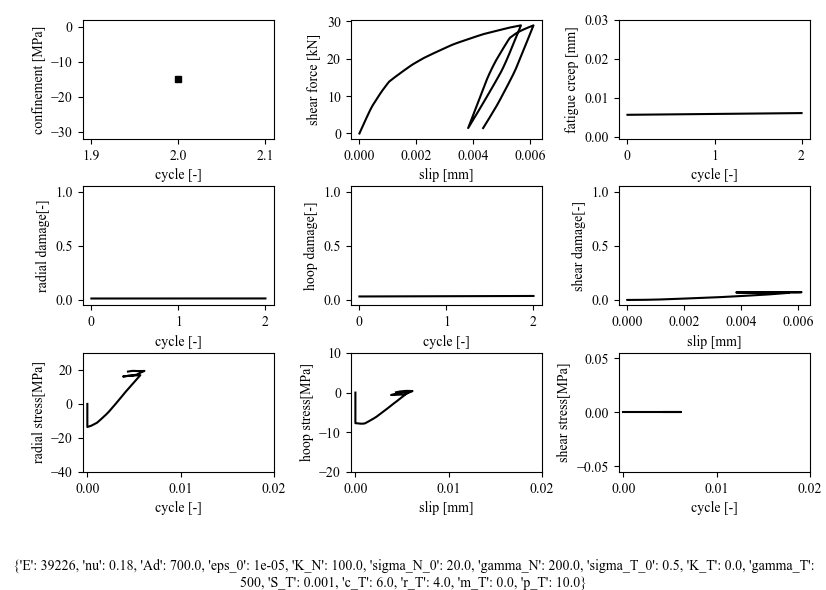

In [22]:
cm = 1/2.54  # centimeters in inches
plt.style.use('grayscale')
N=[]
plt.tight_layout()
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3,figsize=(21*cm, 15*cm))

start = int((shift_cycles+2)*steps_branch)
end = int(steps_branch)
plt.tight_layout()

for m,compression in zip(m_list,compression_level):
    # m = m_list[0]
    # compression = compression_level[3]
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    cycles = np.linspace(0, len(U_slide[start::steps_branch*2]),len(U_slide[start:-steps_branch:steps_branch*2]))

    # print(U_slide[start::steps_branch].shape)
    radial_damage, hoop_damage, shear_damage = get_damage(m)
    U_dilatancy = np.average(m.hist.U_t[:, confinement_upper_dofs], axis=-1)
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    print(cycles)
    # print(F_slide[start::steps_branch*2].shape)
    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)

    N.append(cycles[-1])
    # ax1.plot(cycles, F_confinement[start:-steps_branch:steps_branch*2]/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    # ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    ax1.set_ylabel('confinement [MPa]')
    ax1.set_xlabel('cycle [-]')
    # ax1.set_xlim(-5,55)

    ax2.plot(U_slide, F_slide/1000, label=str(compression))
    ax2.set_ylabel('shear force [kN]')
    ax2.set_xlabel('slip [mm]')
    # ax2.set_ylim(-1,130)
    # ax2.set_xlim(-0.0005,0.02)

    ax3.plot(cycles, U_slide[start:-end:steps_branch*2], label=str(compression))
    # ax3.plot(cycles[1:], U_slide[start+steps_branch:-end:steps_branch*2], label=str(compression))
    ax3.set_ylabel('fatigue creep [mm]')
    ax3.set_xlabel('cycle [-]')
    ax3.set_ylim(-0.0005,0.03)


    ax4.plot(cycles, radial_damage[start:-end:steps_branch*2], label='radial damage'+str(compression))
    ax4.set_ylabel('radial damage[-]')
    ax4.set_xlabel('cycle [-]')
    ax4.set_ylim(-0.05,1.05)

    ax5.plot(cycles, hoop_damage[start:-end:steps_branch*2], label='hoop damage'+str(compression))
    ax5.set_ylabel('hoop damage[-]')
    ax5.set_xlabel('cycle [-]')
    ax5.set_ylim(-0.05,1.05)

    # ax6.plot(cycles, shear_damage[start:-end:steps_branch*2], label='shear damage'+str(compression))
    ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
    ax6.set_ylabel('shear damage[-]')
    ax6.set_xlabel('slip [mm]')
    ax6.set_ylim(-0.05,1.05)

    sigma_radial, sigma_hoop, sigma_shear = get_sigma(m,3)  

    ax7.plot(U_slide, sigma_radial)
    # ax7.plot(cycles, sigma_radial[start:-end:steps_branch*2])
    ax7.set_ylabel('radial stress[MPa]')
    ax7.set_xlabel('cycle [-]')
    ax7.set_xlim(-0.0005,0.02)
    ax7.set_ylim(-40,30)

    ax8.plot(U_slide, sigma_hoop)
    # ax8.plot(cycles, sigma_hoop[start:-end:steps_branch*2])
    ax8.set_ylabel('hoop stress[MPa]')
    ax8.set_xlabel('slip [mm]')
    ax8.set_xlim(-0.0005,0.02)
    ax8.set_ylim(-20,10)

    ax9.plot(U_slide, sigma_shear)
    # ax9.plot(cycles, sigma_shear[start:-end:steps_branch*2])
    ax9.set_ylabel('shear stress[MPa]')
    ax9.set_xlabel('cycle [-]')
    ax9.set_xlim(-0.0005,0.02)

ax1.plot(N, compression_level,  '--ks', markersize=4)  

left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# ax1.set_xlim(-1,21)
ax1.set_ylim(-32,2)

# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_cyclic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_cyclic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
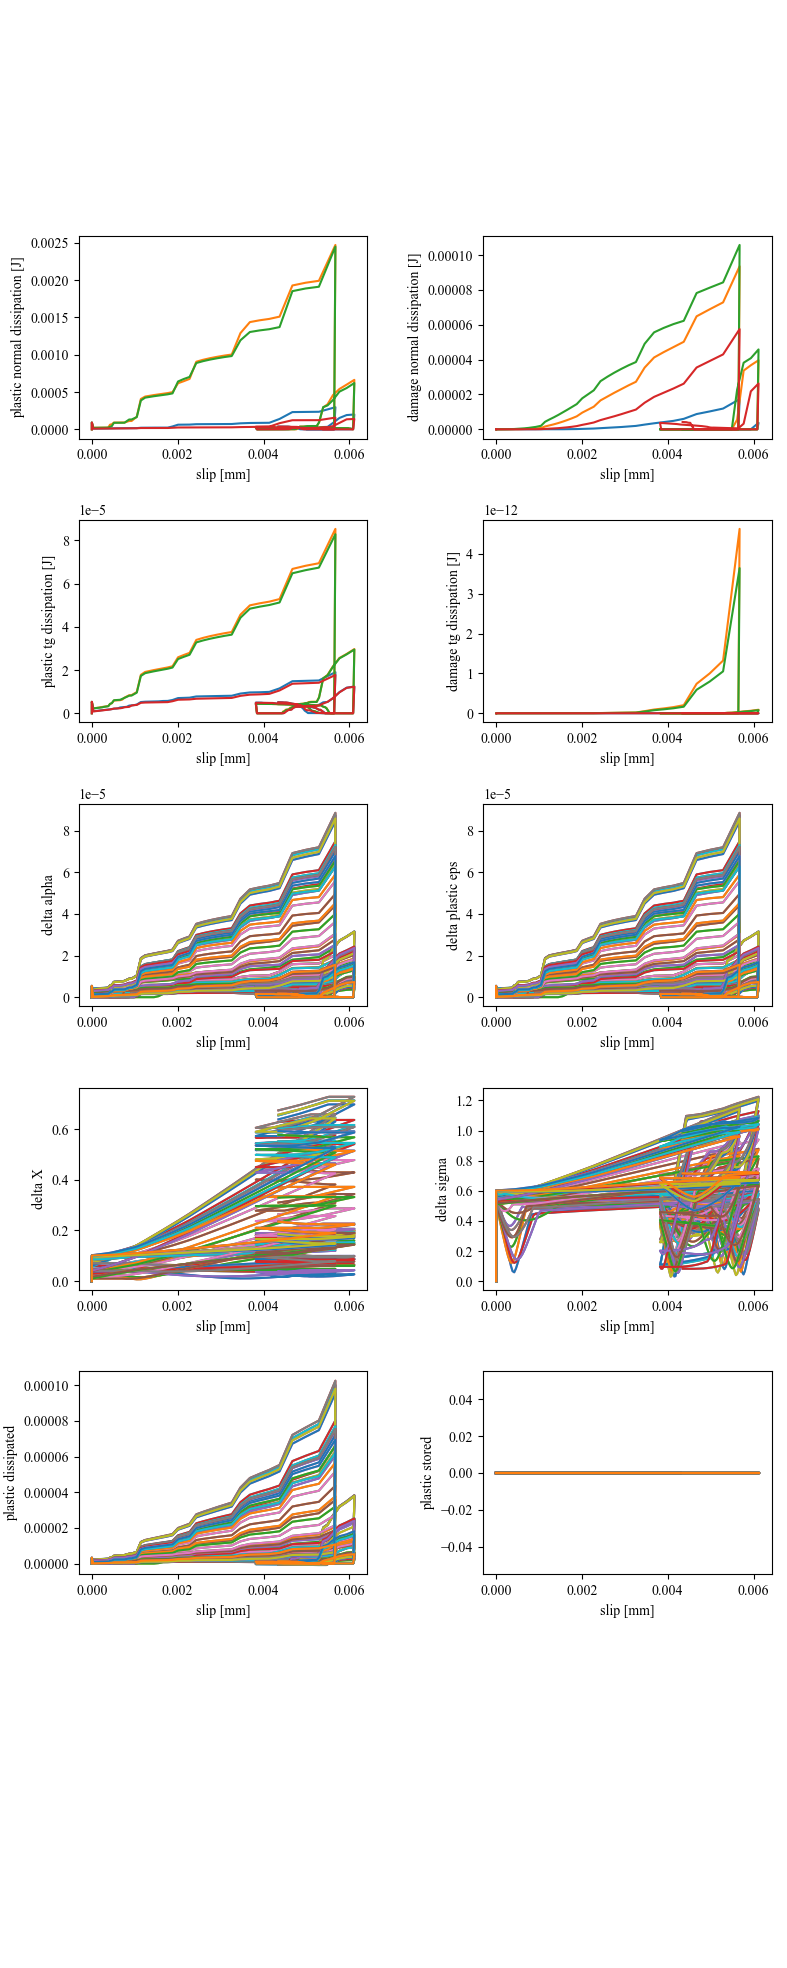

In [24]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5, 2,figsize=(20*cm, 50*cm))

for m,compression in zip(m_list,compression_level):
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    plastic_normal_dissipation, damage_normal_dissipation, plastic_tangential_dissipation, damage_tangential_dissipation, delta_z_T_Emn, delta_alpha_T_Emna, delta_eps_T_pi_Emna, sigma_T_Emna, Z_T, X_T\
    = get_energy_dissip(m)
    
    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    
    ax1.plot(U_slide, plastic_normal_dissipation)
    ax1.set_ylabel('plastic normal dissipation [J]', fontsize=10)
    ax1.set_xlabel('slip [mm]', fontsize=10)
    
    ax2.plot(U_slide, damage_normal_dissipation)
    ax2.set_ylabel('damage normal dissipation [J]', fontsize=10)
    ax2.set_xlabel('slip [mm]', fontsize=10)
    
    ax3.plot(U_slide, plastic_tangential_dissipation)
    ax3.set_ylabel('plastic tg dissipation [J]', fontsize=10)
    ax3.set_xlabel('slip [mm]', fontsize=10)
    
    ax4.plot(U_slide, damage_tangential_dissipation)
    ax4.set_ylabel('damage tg dissipation [J]', fontsize=10)
    ax4.set_xlabel('slip [mm]', fontsize=10)
    
    plastic_dissip = np.einsum('...na,...na->...n', sigma_T_Emna, delta_eps_T_pi_Emna)
    plastic_stored = np.einsum('...na,...na->...n', X_T, delta_alpha_T_Emna)
    plastic_dissip_T_Emn = np.zeros_like(delta_z_T_Emn)
    
    
    for j in range(len(m.hist.state_vars)): 
        plastic_dissip_T_Emn[j] = np.array(m.hist.state_vars[j][0]['plastic_dissip_T_Emn'])
    
    for i in range(len(delta_z_T_Emn[0,0])):
        
        ax5.plot(U_slide, np.linalg.norm(delta_alpha_T_Emna, axis= -1)[:,:,i])
        ax5.set_ylabel('delta alpha', fontsize=10)
        ax5.set_xlabel('slip [mm]', fontsize=10)

        ax6.plot(U_slide, np.linalg.norm(delta_eps_T_pi_Emna, axis= -1)[:,:,i])
        ax6.set_ylabel('delta plastic eps', fontsize=10)
        ax6.set_xlabel('slip [mm]', fontsize=10)

        ax7.plot(U_slide, np.linalg.norm(X_T, axis= -1)[:,:,i])
        ax7.set_ylabel('delta X', fontsize=10)
        ax7.set_xlabel('slip [mm]', fontsize=10)

        ax8.plot(U_slide, np.linalg.norm(sigma_T_Emna, axis= -1)[:,:,i])
        ax8.set_ylabel('delta sigma', fontsize=10)
        ax8.set_xlabel('slip [mm]', fontsize=10)

        ax9.plot(U_slide, plastic_dissip[:,:,i])
        ax9.set_ylabel('plastic dissipated', fontsize=10)
        ax9.set_xlabel('slip [mm]', fontsize=10)
        
        ax10.plot(U_slide, plastic_dissip_T_Emn[:,:,i])
        ax10.set_ylabel('plastic stored', fontsize=10)
        ax10.set_xlabel('slip [mm]', fontsize=10)
    
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
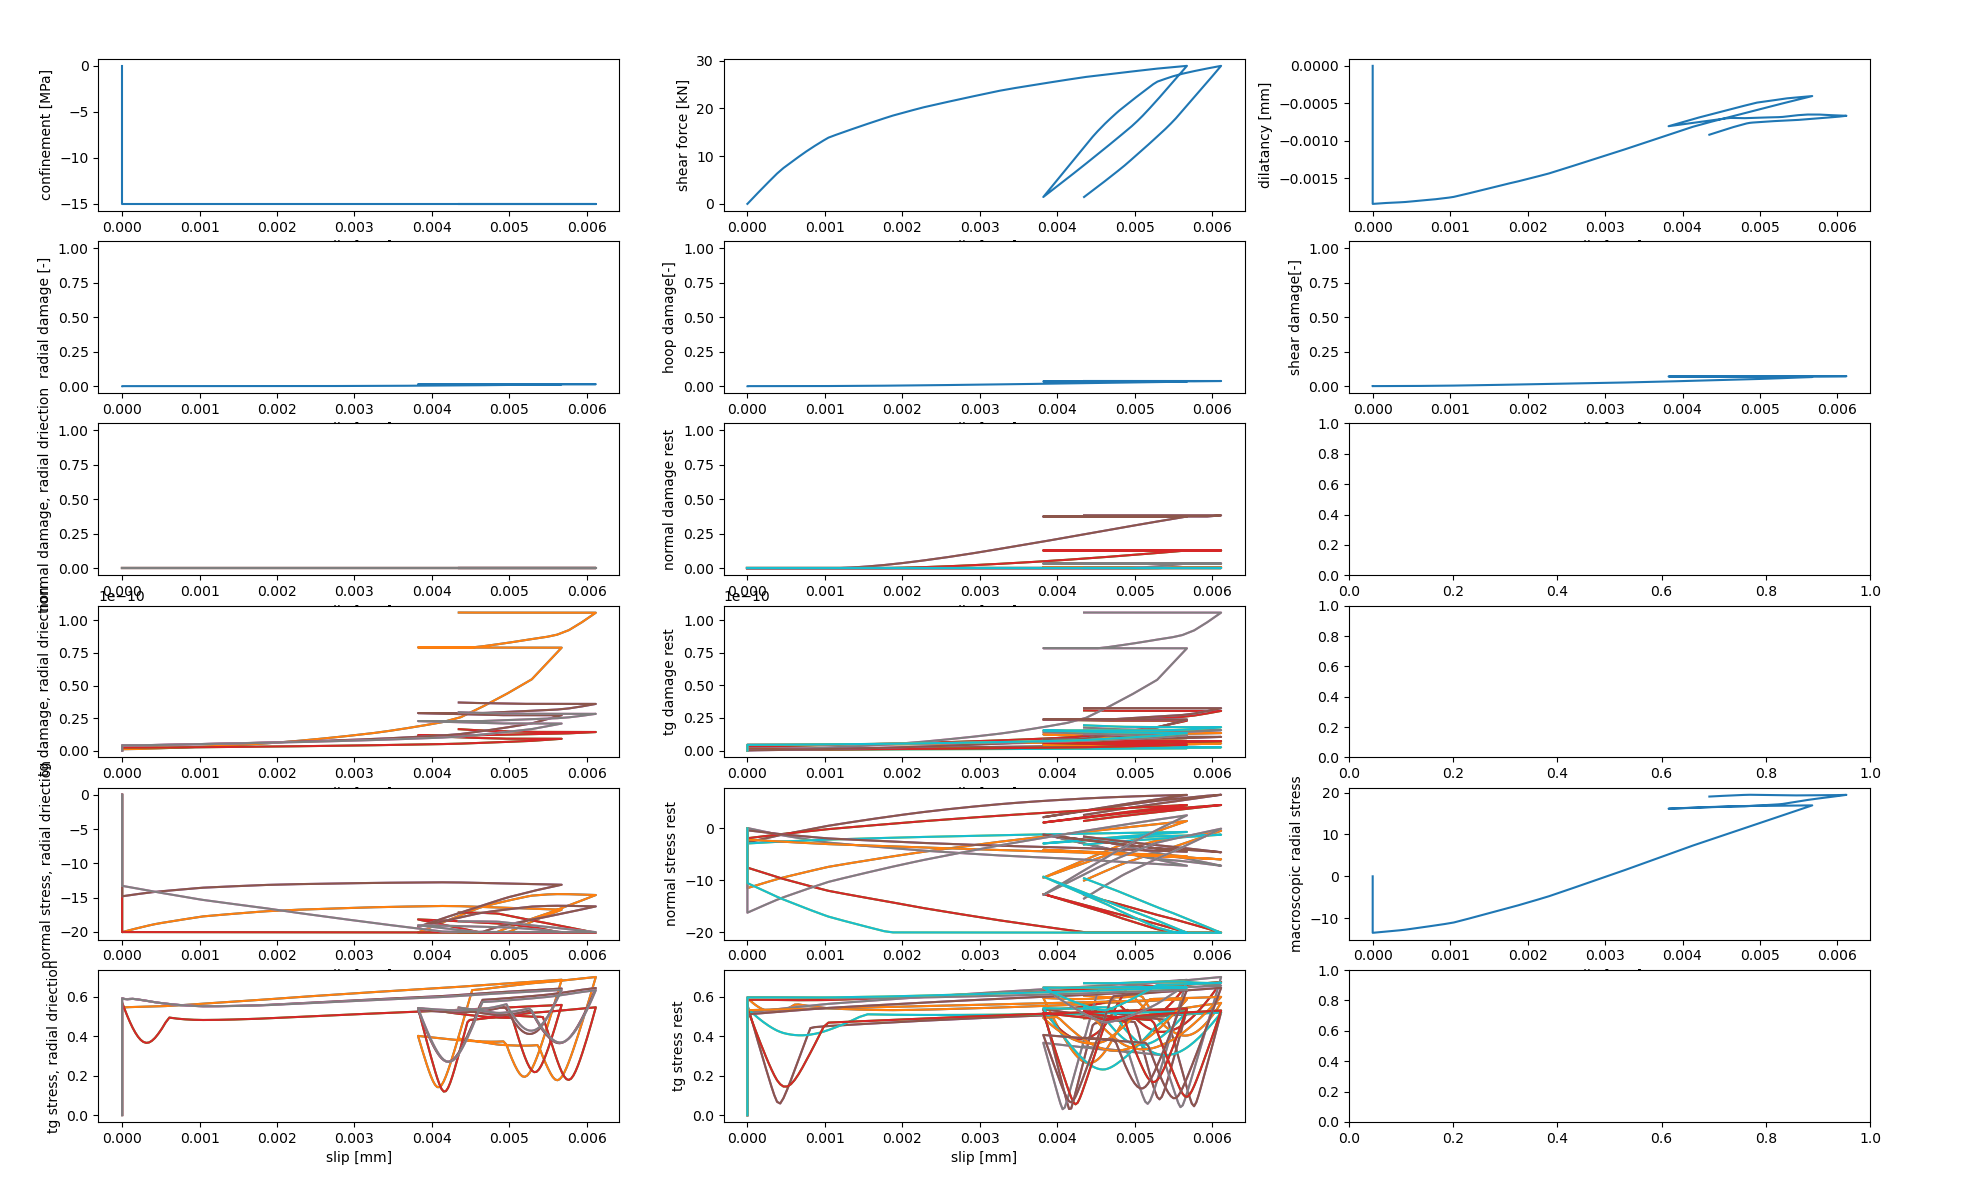

In [81]:
plt.style.use('default')

# plt.tight_layout()

cm = 1/2.54  # centimeters in inches
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9), (ax10,ax11,ax12), (ax13,ax14,ax15), (ax16,ax17,ax18)) = plt.subplots(6, 3,figsize=(50*cm, 30*cm))

# txt=str(CAxisymm)


idx = 0
m = m_list[idx]
# compression = compression_level[idx]
# plt.rcParams["font.family"] = "Times New Roman"
 
    
U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
radial_damage, hoop_damage, shear_damage = get_damage(m)

F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)


ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
ax1.set_ylabel('confinement [MPa]', fontsize=10)
ax1.set_xlabel('slip [mm]', fontsize=10)

ax2.plot(U_slide, F_slide/1000, label=str(compression))
ax2.set_ylabel('shear force [kN]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)
# ax2.set_xlim(-0.002,0.03)

ax3.plot(U_slide, U_dilatancy, label=str(compression))
ax3.set_ylabel('dilatancy [mm]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)
# ax3.set_xlim(-0.002,0.03)


# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.set_ylabel('radial damage [-]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
ax4.set_ylim(-0.05,1.05)
# ax4.set_xlim(-0.002,0.03)


ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
ax5.set_ylabel('hoop damage[-]', fontsize=10)
ax5.set_xlabel('slip [mm]', fontsize=10)
ax5.set_ylim(-0.05,1.05)
# ax5.set_xlim(-0.002,0.03)

# ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
ax6.set_ylabel('shear damage[-]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)
ax6.set_ylim(-0.05,1.05)
# ax6.set_xlim(-0.002,0.03)

omega_N_01, omega_N_11 = get_omega_N(m) 
ax7.plot(U_slide, omega_N_11)
ax7.set_ylabel('normal damage, radial driection', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)
ax7.set_ylim(-0.05,1.05)
# ax7.set_xlim(-0.002,0.03)


ax8.plot(U_slide, omega_N_01, label='shear damage'+str(compression))
ax8.set_ylabel('normal damage rest', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
ax8.set_ylim(-0.05,1.05)
# ax8.set_xlim(-0.002,0.03)

omega_T_01, omega_T_11 = get_omega_T(m) 
ax10.plot(U_slide, omega_T_11)
ax10.set_ylabel('tg damage, radial driection', fontsize=10)
ax10.set_xlabel('slip [mm]', fontsize=10)
# ax10.set_ylim(-0.05,1.05)
# ax10.set_xlim(-0.002,0.03)


ax11.plot(U_slide, omega_T_01, label='shear damage'+str(compression))
ax11.set_ylabel('tg damage rest', fontsize=10)
ax11.set_xlabel('slip [mm]', fontsize=10)
# ax11.set_ylim(-0.05,1.05)
# ax11.set_xlim(-0.002,0.03)
    
sigma_N_01, sigma_N_11, sigma_T_01, sigma_T_11, sigma_radial = get_sigma_N(m) 
ax13.plot(U_slide, sigma_N_11)
ax13.set_ylabel('normal stress, radial driection', fontsize=10)
ax13.set_xlabel('slip [mm]', fontsize=10)
# ax13.set_ylim(-0.05,1.05)


ax14.plot(U_slide, sigma_N_01, label='shear damage'+str(compression))
ax14.set_ylabel('normal stress rest', fontsize=10)
ax14.set_xlabel('slip [mm]', fontsize=10)
# ax14.set_ylim(-0.05,1.05)

ax15.plot(U_slide, sigma_radial)
ax15.set_ylabel('macroscopic radial stress', fontsize=10)
ax15.set_xlabel('slip [mm]', fontsize=10)

ax16.plot(U_slide, sigma_T_11)
ax16.set_ylabel('tg stress, radial driection', fontsize=10)
ax16.set_xlabel('slip [mm]', fontsize=10)
# ax13.set_ylim(-0.05,1.05)


ax17.plot(U_slide, sigma_T_01, label='shear damage'+str(compression))
ax17.set_ylabel('tg stress rest', fontsize=10)
ax17.set_xlabel('slip [mm]', fontsize=10)
# ax14.set_ylim(-0.05,1.05)

left  = 0.05  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)